**Домашнее задание**


1. *Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.

2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred)

5. *Реализуйте функции для подсчета Accuracy, матрицы ошибок, точности и полноты, а также F1 score.

6. Могла ли модель переобучиться? Почему?

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [192]:
X = np.array([ [   1,    1,  500,    1],
               [   1,    1,  700,    1],
               [   1,    2,  750,    2],
               [   1,    5,  600,    1],
               [   1,    3, 1450,    2],
               [   1,    0,  800,    1],
               [   1,    5, 1500,    3],
               [   1,   10, 2000,    3],
               [   1,    1,  450,    1],
               [   1,    2, 1000,    2]], dtype=np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype=np.float64)

In [193]:
print(X)

[[1.00e+00 1.00e+00 5.00e+02 1.00e+00]
 [1.00e+00 1.00e+00 7.00e+02 1.00e+00]
 [1.00e+00 2.00e+00 7.50e+02 2.00e+00]
 [1.00e+00 5.00e+00 6.00e+02 1.00e+00]
 [1.00e+00 3.00e+00 1.45e+03 2.00e+00]
 [1.00e+00 0.00e+00 8.00e+02 1.00e+00]
 [1.00e+00 5.00e+00 1.50e+03 3.00e+00]
 [1.00e+00 1.00e+01 2.00e+03 3.00e+00]
 [1.00e+00 1.00e+00 4.50e+02 1.00e+00]
 [1.00e+00 2.00e+00 1.00e+03 2.00e+00]]


In [194]:
print(y)

[0. 0. 1. 0. 1. 0. 1. 0. 1. 1.]


In [195]:
def standard_scale(x):
    res = (x - x.mean()) / x.std()
    return res

In [196]:
X_st = X.copy()
X_st[:, 2] = standard_scale(X[:, 2])

In [197]:
X_st[:, 2]

array([-0.97958969, -0.56713087, -0.46401617, -0.77336028,  0.97958969,
       -0.36090146,  1.08270439,  2.11385144, -1.08270439,  0.05155735])

In [198]:
from numpy import ma
def calc_logloss(y, y_pred):

    # err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))

    # Первый способ, который я нашел в мануале к библиотеке numpy, в которой есть модуль ma с разными методами
    err = - np.mean(y * ma.log(y_pred) + (1.0 - y) * ma.log(1.0 - y_pred))

    # Второй способ, но доверие вызывает первый найденный способ. Какой же метод правильный?
    #err = - np.mean(y * ma.filled(np.log(ma.masked_equal(y_pred, 0)), 0) + (1.0 - y) * ma.filled(np.log(ma.masked_equal((1.0 - y_pred), 0)), 0))

    # Третий вариант решения проблемы. But, where is true?
    # err = - np.mean(y * np.log(y_pred + 1e-20) + (1.0 - y) * np.log(1.0 - y_pred + 1e-20))

    return err

In [199]:
# Пример применения
y1 = np.array([1, 0])
y_pred1 = np.array([0.8, 0.1])
calc_logloss(y1, y_pred1)

0.164252033486018

In [200]:
# Пример применения функции calc_logloss в крайних значениях вероятности
y1 = np.array([1, 0])
y_pred1 = np.array([0.7, 1])
calc_logloss(y1, y_pred1)

0.35667494393873245

Посмотрел, какие значения заменяются и как. Интересные возможности у модуля ma. Как можно видеть, заменяются крайние значения 0 и 1 на 1e+20

In [201]:
y_pred1 = np.array([0.7, 1])
y_pred1.view(ma.MaskedArray)

masked_array(data=[0.7, 1. ],
             mask=False,
       fill_value=1e+20)

In [202]:
y_pred1 = np.array([0.7, 0])
y_pred1.view(ma.MaskedArray)

masked_array(data=[0.7, 0. ],
             mask=False,
       fill_value=1e+20)

In [203]:
# Реализация функции сигмоид
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

In [204]:
z = np.linspace(-10, 10, 101)

In [205]:
probabilities = sigmoid(z)

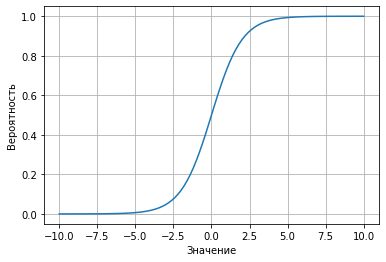

In [206]:
plt.plot(z, probabilities)
plt.grid()
plt.xlabel('Значение')
plt.ylabel('Вероятность')
plt.show()

In [207]:
# Функция для обучения логистической регрессии
def eval_model(X, y, iterations, eta):
    np.random.seed(42)
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    
    for i in range(iterations):
        z = np.dot(X, W)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        
        dQ = 1/n * X.T @ (y_pred - y)
        W -= eta * dQ
        if i % (iterations / 10) == 0:
            print(f'Iteration {i}, Weights {W}, Error {err}')
    print(f'Iteration {i}, Weights {W}, Error {err}')
    return W

In [208]:
W = eval_model(X_st, y, iterations=2000, eta=5e-1)

Iteration 0, Weights [ 0.30702071 -0.8637023   0.63399833  1.23995672], Error 1.1785958344356262
Iteration 200, Weights [-2.53264337 -0.94588146  0.39552518  3.14199572], Error 0.3752284697746543
Iteration 400, Weights [-4.28744535 -0.98196006 -0.2781919   4.26931712], Error 0.3265546604744958
Iteration 600, Weights [-5.56950119 -1.03216267 -0.74142878  5.15783361], Error 0.2998616158977683
Iteration 800, Weights [-6.59307924 -1.08615127 -1.09354157  5.90394621], Error 0.2824776604055235
Iteration 1000, Weights [-7.46176644 -1.1397904  -1.38249421  6.5578009 ], Error 0.2697605571663567
Iteration 1200, Weights [-8.22951246 -1.19196588 -1.63182265  7.14808224], Error 0.25971627629974436
Iteration 1400, Weights [-8.92678929 -1.24245    -1.85427212  7.69204644], Error 0.2513651405495681
Iteration 1600, Weights [-9.57202992 -1.29127697 -2.05732739  8.20061177], Error 0.24417283112673355
Iteration 1800, Weights [-10.1770298   -1.3385517   -2.24567523   8.68100834], Error 0.23782320135351806


In [209]:
print(f'Weights {W}')

Weights [-10.74690483  -1.38416322  -2.42154793   9.13598506]


In [226]:
# Функция для предсказания вероятности быть целевым классом
def calc_pred_proba(W, X):
  return sigmoid(np.dot(X, W))

In [227]:
y_pred_proba = calc_pred_proba(W, X_st)
print(y_pred_proba)

[0.34910863 0.16496389 0.99721405 0.00128078 0.73114749 0.32366498
 0.9991906  0.09117478 0.40775294 0.99035754]


In [212]:
# Функция предсказания класса
def calc_pred(W, X, edge):
  m = X.shape[0]
    
  y_pred = np.zeros(m)

  A = np.squeeze(sigmoid(np.dot(X, W)))

  # За порог отнесения к тому или иному классу примем вероятность равную edge
  for i in range(A.shape[0]):
      if A[i] > edge: 
        y_pred[i] = 1
      elif A[i] <= edge:
        y_pred[i] = 0
  return y_pred

In [228]:
y_pred = calc_pred(W, X_st, 0.4)
print(y_pred)

[0. 0. 1. 0. 1. 0. 1. 0. 1. 1.]


In [229]:
# Функция для формирования матрицы ошибок
def get_matrix_errors(y, y_pred):
    TP = (y[y_pred == 1] == y_pred[y_pred ==1 ]).sum()
    FP = (y[y_pred == 1]!= y_pred[y_pred == 1]).sum()
    FN = (y[y_pred == 0]!= y_pred[y_pred == 0]).sum()
    TN = (y[y_pred == 0] == y_pred[y_pred == 0]).sum()
    return np.array([[TP, FP],
                     [FN, TN]])

In [230]:
m_errors = get_matrix_errors(y, y_pred)
print(m_errors)

[[5 0]
 [0 5]]


In [231]:
def get_metrics(matrix_erros):
  TP = matrix_erros[0][0]
  FP = matrix_erros[0][1]
  FN = matrix_erros[1][0]
  TN = matrix_erros[1][1]

  accuracy = (TP + TN) / (TP + FP + FN + TN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1_score = 2 * precision * recall / (precision + recall)
  
  return accuracy, precision, recall, f1_score

In [232]:
accuracy, precision, recall, f1_score = get_metrics(m_errors)

In [233]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1_score: 1.0


Проект *:

https://www.kaggle.com/c/gb-tutors-expected-math-exam-results 
регрессия

https://www.kaggle.com/c/gb-choose-tutors 
классификация

**Дополнительные материалы**

1. [Функции потерь для классификации](https://en.wikipedia.org/wiki/Loss_functions_for_classification)

2. Метод максимального правдоподобия: [Сложное описание](https://habr.com/ru/company/ods/blog/323890/#metod-maksimalnogo-pravdopodobiya) / [Простое описание](https://www.youtube.com/watch?v=2iRIqkm1mug)

3. [Встроенные датасеты Sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)

4. Площаль под кривой [numpy.trapz](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.trapz.html)
5. [Видео про метрику Accuracy](https://youtu.be/CCH-1gJo_z0)
6. [Видео про метрики Precision, Recall](https://youtu.be/AfnBHL832Eg)
7. [Видео про метрику F-score](https://youtu.be/PeE3Fkt5W3Q)
8. [Видео про метрику PR-AUC](https://youtu.be/QW-09jHQH-w)